In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('sampled_data_25k.csv')

df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,hour
0,2019-11-01 16:29:07+00:00,view,2500962,2053013564003713919,appliances.kitchen.oven,electrolux,463.20,516216750,026c0439-7540-4963-aba7-e753bd2a4ad3,16
1,2019-11-02 13:26:31+00:00,view,9600155,2053013561185141473,NaN,dji,468.19,512783488,080c2e91-e335-4a89-a889-0a5a619f9051,13
2,2019-11-01 17:49:29+00:00,view,14700670,2053013557133443581,furniture.living_room.cabinet,sv,123.53,513741357,a7685abc-71cf-45b3-9870-d344847fba0f,17
3,2019-11-01 14:50:45+00:00,view,3600145,2053013563810775923,appliances.kitchen.washer,indesit,169.63,530256322,a5ed5609-800d-4e95-a631-dd86d2da2b98,14
4,2019-11-02 08:18:23+00:00,view,18000258,2053013558525952589,NaN,samsung,6.41,512777444,ae2564fd-5166-4216-8914-77b16b0bae45,8


In [3]:
#verificar cantidad de valores nulos

nulos = df.isnull().sum()
print('la cantidad de valores nulos es de:\n',nulos)

#verificar cantidad de valores duplicados

duplicados = df.duplicated().sum()
print('la cantidad de valores duplicados es de: ',duplicados)

la cantidad de valores nulos es de:
 event_time          0
event_type          0
product_id          0
category_id         0
category_code    8116
brand            3665
price               0
user_id             0
user_session        0
hour                0
dtype: int64
la cantidad de valores duplicados es de:  0


In [4]:
# Rellenar los nulos en 'category_code' y 'brand' con 'desconocido'
df['category_code'].fillna('desconocido', inplace=True)
df['brand'].fillna('desconocido', inplace=True)

# Verificar los cambios
print(df.isnull().sum())

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
hour             0
dtype: int64


# Modelo SVM

In [5]:
#Importar librerías
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve


In [6]:
#Revisar la distribución de la variable objetivo

df['event_type'].unique()


array(['view', 'cart', 'purchase'], dtype=object)

In [7]:
#Transformar la variable a binario
df['event_type'] = df['event_type'].apply(lambda x: 1 if x == 'purchase' else 0)

#Realizar One Hot encoding para variables categoricas
df = pd.get_dummies(df, columns=['brand', 'category_code'], drop_first=True)

#Normalización de la variable 'price'
scaler = StandardScaler()
df['price'] = scaler.fit_transform(df[['price']])

#Quitar columnas innecesarias
df = df.drop(columns=['event_time', 'product_id', 'category_id', 'user_id', 'user_session', 'hour'])

In [8]:
#Observar la distribución de la variable

df['event_type'].value_counts()

event_type
0    24645
1      355
Name: count, dtype: int64

In [18]:
df

,event_type,price,brand_a-derma,brand_accord,brand_acer,brand_acm,brand_acme,brand_acv,brand_adamex,brand_addlink,...,category_code_kids.fmcg.diapers,category_code_kids.skates,category_code_kids.swing,category_code_kids.toys,category_code_medicine.tools.tonometer,category_code_sport.bicycle,category_code_sport.ski,category_code_sport.snowboard,category_code_sport.trainer,category_code_stationery.cartrige
0,0,0.488911,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,0.503177,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,-0.482179,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,-0.350383,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,-0.817016,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,-0.180449,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
24996,0,-0.808925,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
24997,0,-0.295177,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
24998,0,-0.549821,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [19]:
#pasar nuevo df a csv 
df.to_csv('sampled_data_25k_preprocesado.csv', index=False)

In [9]:
#Realizar sobre muestreo

#Separar características y variable objetivo
X = df.drop(columns=['event_type'])
y = df['event_type']

# Aplicar SMOTE para balancear el conjunto de datos
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#Comprobar la nueva distribución de 'event_type' después de SMOTE
print(y_resampled.value_counts())

event_type
0    24645
1    24645
Name: count, dtype: int64


In [10]:
#Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [11]:
#Inicializar y entrenar el modelo SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)


SVC()

In [12]:
#Realizar predicciones en el conjunto de prueba
y_pred = svm_model.predict(X_test)

#Mostrar el reporte de clasificación y la matriz de confusión
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.72      0.79      7381
           1       0.76      0.90      0.83      7406

    accuracy                           0.81     14787
   macro avg       0.82      0.81      0.81     14787
weighted avg       0.82      0.81      0.81     14787

[[5322 2059]
 [ 757 6649]]


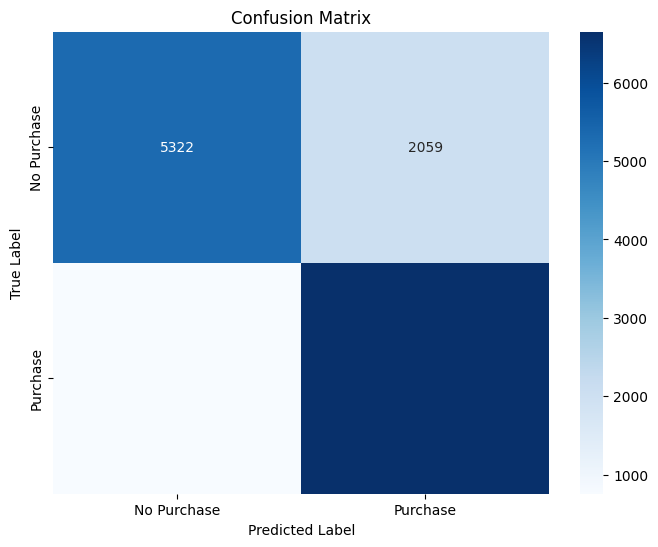

In [13]:
#Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

#Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Purchase', 'Purchase'], yticklabels=['No Purchase', 'Purchase'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


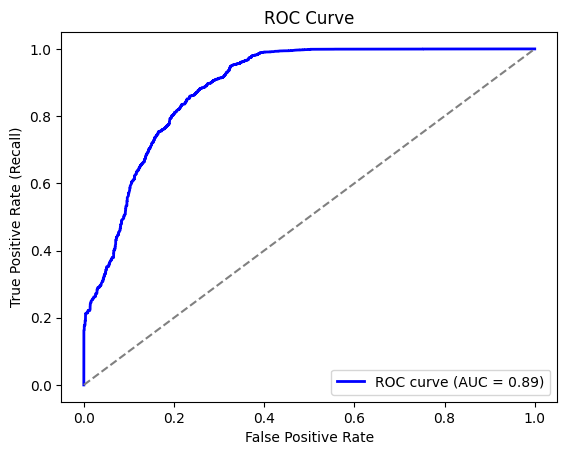

In [14]:
#Obtener las probabilidades de predicción para la clase positiva
y_scores = svm_model.decision_function(X_test)

#Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

#Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea aleatoria
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


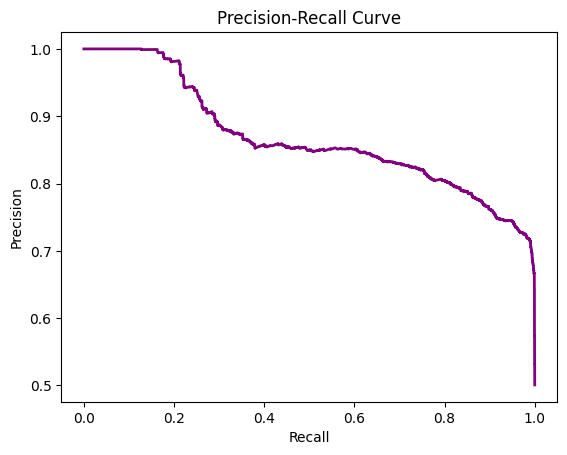

In [15]:
#Calcular la curva de Precisión-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

#Graficar la curva
plt.figure()
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [17]:
import joblib

# Guardar el scaler
joblib.dump(scaler, 'scaler.pkl')  # Guardar el scaler entrenado

# Guardar el modelo SVM
joblib.dump(svm_model, 'svm_model.pkl')  # Guardar el modelo SVM entrenado

['svm_model.pkl']

In [21]:
for column in svm_model.feature_names_in_:
    print(column)
    

price
brand_a-derma
brand_accord
brand_acer
brand_acm
brand_acme
brand_acv
brand_adamex
brand_addlink
brand_adidas
brand_adil
brand_adile
brand_adriatica
brand_aero
brand_aerocool
brand_aeroforce
brand_afnan
brand_afox
brand_agness
brand_agu
brand_aimoto
brand_air-cool
brand_akai
brand_akom
brand_akpo
brand_akvaton
brand_alcon
brand_aldit
brand_alesis
brand_alilo
brand_alis
brand_alkor
brand_alligator
brand_allvega
brand_almacom
brand_almada
brand_alphard
brand_alpina
brand_alpine
brand_alser
brand_alteco
brand_alutec
brand_alvitek
brand_am.pm
brand_amalbooks
brand_amazon
brand_amd
brand_amf
brand_amouage
brand_ams
brand_amtel
brand_anex
brand_annaanna
brand_anskin
brand_ansmann
brand_anytek
brand_aoc
brand_aoteli
brand_apacer
brand_apache
brand_aplus
brand_apollo
brand_apple
brand_appollo
brand_aqua
brand_aquamarine
brand_aquapick
brand_ardahali
brand_arg
brand_ariete
brand_ariston
brand_ark
brand_armani
brand_arms
brand_arnica
brand_arrivo
brand_arsi
brand_artel
brand_artmusical
bran